In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division

In [3]:
import pandas as pd
import seaborn as sns
#sns.set_style("whitegrid")
sns.set_style("darkgrid")
#sns.set_style("white")
sns.set_style("dark")
#sns.set_style("ticks")

C:\Users\Armand\AppData\Local\Enthought\Canopy\User\lib\site-packages\pandas\io\excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


# Question Dataset Cleaning

In [48]:
# Importing the dataset created with Monary
df = pd.read_csv("BaseQuestionsNomsPSE",index_col=0)

# Formatting dates to be in format pandas.DataFrame.datetime64 in ms
df["date updated"] = df["date updated"].astype("datetime64[ms]")
df["date created"]=df["date created"].astype("datetime64[ms]")

# Sorting data by user and by date of the attempt
df = df.sort(["user id","date created"]).reset_index(drop=True)

# Adding a day column in order to do day by day analysis
df['day'] =  pd.DatetimeIndex(df['date created']).date
df_ta['day'] =  pd.DatetimeIndex(df_ta['date created']).date
df = df[df['day'] >= pd.to_datetime('20160912', format='%Y%m%d').date()]

value_to_select = df["map name"].isin(df["map name"].value_counts().keys() - [u'3. Hypothesis testing', u'2. Point estimation'])
df = df[value_to_select].reset_index(drop=True)

# Test Attempt Dataset Cleaning

In [5]:
#Importing the test attempt dataset
df_ta = pd.read_csv("BaseTravailPSE", index_col=0)

df_ta = df_ta[pd.to_datetime(df_ta['date created']).apply(lambda x: x.date()) > pd.to_datetime('20160912', format='%Y%m%d').date()]
#Adding the duration of a test attempt
df_ta["duration"] = (df_ta["date finished"].astype("datetime64")-df_ta["date created"].astype("datetime64"))

#Some test attempt were not completed and thus got the date 1 jan 1970 for 'date finished' we have to drop them
df_ta = df_ta[df_ta["duration"] > pd.to_timedelta("0 days")].reset_index(drop=True)

df_ta['count'] = np.ones(len(df_ta))

df_ta['duration in min'] = (df_ta["duration"]/ np.timedelta64(1, 'm'))

In [39]:
df_ta.head()

,Capsule id,capsule name,Test Attempt id,date created,date finished,user id,is completed,is succeeded,score,user name,duration,count,duration in min,date,hour
0,57485297dfb7b83ecce16494,Hypothesis testing - Basics,57e8fd19215c77000b17f19d,2016-09-26 10:48:57.484,2016-09-26 10:55:29.364,57485ef0dfb7b83ecce1f01c,True,False,0.7,Marc Gurgand,00:06:31.880000,1,6.531333,2016-09-26,10
1,57485297dfb7b83ecce16494,Hypothesis testing - Basics,57e8fea7215c77000b183f9f,2016-09-26 10:55:34.970,2016-09-26 10:57:05.411,57485ef0dfb7b83ecce1f01c,True,True,1.0,Marc Gurgand,00:01:30.441000,1,1.507350,2016-09-26,10
2,57485297dfb7b83ecce16494,Hypothesis testing - Basics,57ece71fbcb73c000bdf9144,2016-09-29 10:04:15.730,2016-09-29 19:02:07.065,57d68a8cda26e0000b00431c,True,False,0.6,Christian Abele,08:57:51.335000,1,537.855583,2016-09-29,10
3,57485297dfb7b83ecce16494,Hypothesis testing - Basics,57ed65377325ac000b693124,2016-09-29 19:02:15.877,2016-09-29 19:08:16.792,57d68a8cda26e0000b00431c,True,True,0.9,Christian Abele,00:06:00.915000,1,6.015250,2016-09-29,19
4,57485297dfb7b83ecce16494,Hypothesis testing - Basics,57ecd497bcb73c000bdb30f5,2016-09-29 08:45:11.029,2016-09-29 08:55:06.767,57d68a8dda26e0000b004322,True,False,0.3,Léa Ambroise,00:09:55.738000,1,9.928967,2016-09-29,8


In [6]:
df_map = pd.read_csv("BaseMapPSE",index_col=0)

# Adding map names to test attempts
df_ta_m = (pd.merge(left=df_ta,right=df_map,on="Capsule id",how="inner"))
df_ta_m2 = df_ta_m[df_ta_m['map name'].isin(list((set(df_ta_m['map name'])) - set([u'3. Hypothesis testing', u'2. Point estimation'])))]

# Atlas : Probability and Statistics

In [7]:
len(df)

12615

There are 11796 answers in the dataset. We will now find a threshold to distinguish people who took way too many time to answer.

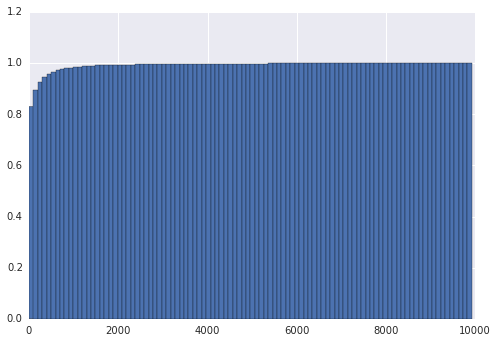

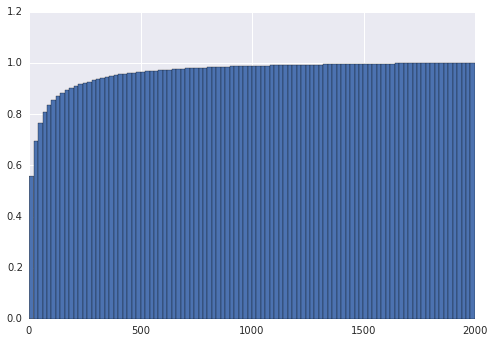

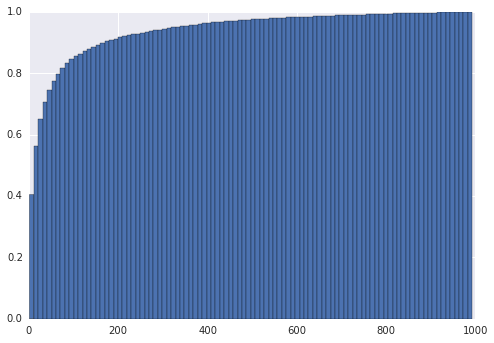

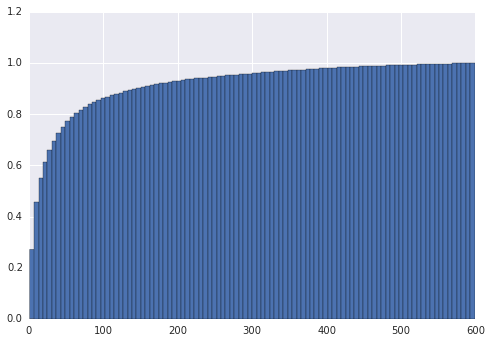

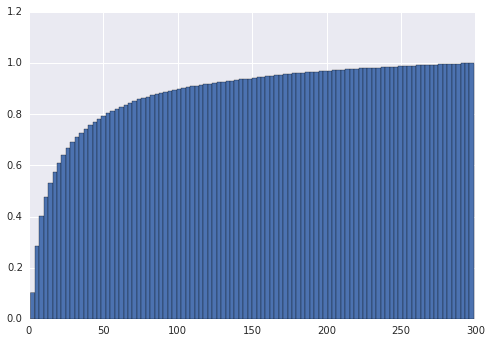

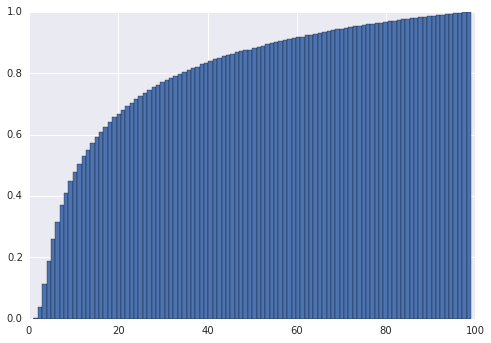

In [8]:

for i in [10000,2000,1000,600,300,100]:
    plt.figure()
    plt.legend(str(i))
    df[df["duration"] <= i]["duration"].apply(int).hist(cumulative=True,bins=100,normed=True)

We keep people who spent more than 20 minutes on a single question:

In [9]:
print "There are %i students attending this course." % len(df['user id'].value_counts())

There are 29 students attending this course.


In [10]:
print "There are %i Test Attempts in the Test Attempt dataset" % len(df_ta['Test Attempt id'].value_counts())

There are 1852 Test Attempts in the Test Attempt dataset


In [11]:
print 'We have data for %i capsules' % (len(df['Capsule id'].value_counts()))

We have data for 30 capsules


In [12]:
print 'Validation rate is %f, with standard deviation %f' % (df_ta['is succeeded'].mean(),df_ta['is succeeded'].std())

Validation rate is 0.379050, with standard deviation 0.485282


In [13]:
df['count'] = np.ones(len(df))
stat_answer_per_user = (df.groupby('user id').sum())['count'].describe()
print """There is in average %i answers per user,
\n with a standard error of %f answers,
\n a minimum of %f answers ,
\n a maximum of %f answers """% (
    stat_answer_per_user['mean'],
    stat_answer_per_user['std'],
    stat_answer_per_user['min'],
    stat_answer_per_user['max']
)

There is in average 435 answers per user,

 with a standard error of 211.322536 answers,

 a minimum of 2.000000 answers ,

 a maximum of 875.000000 answers 


In [14]:
df['count'] = np.ones(len(df))

In [15]:
df_grouped_by_day = (df.groupby('day').sum())['count']
stat_answer_per_day = df_grouped_by_day.describe()
print """There is in average %i answers per day,
\n with a standard error of %f answers,
\n a minimum of %i answers for %s ,
\n a maximum of %i answers for %s """% (
    stat_answer_per_day['mean'],
    stat_answer_per_day['std'],
    stat_answer_per_day['min'],
    argmin(df_grouped_by_day),
    stat_answer_per_day['max'],
    argmax(df_grouped_by_day)
)

There is in average 504 answers per day,

 with a standard error of 511.133544 answers,

 a minimum of 6 answers for 2016-09-21 ,

 a maximum of 2172 answers for 2016-09-30 


In [16]:
print 'Average score per question is %i %%' % (int(100*(df['success'].mean()))+1)

Average score per question is 71 %


# 1. Properties of random samples (13 capsules)

In [17]:
df_ta1 = df_ta_m[df_ta_m['map name'] == '1. Properties of random samples']
df1 = df[df['map name'] == '1. Properties of random samples']

print " In this map there are %i test attempts.\n\n" % len(df_ta1['Test Attempt id'].value_counts())

print ' Validation rate is %f, with standard deviation %f \n\n' % (df_ta1['is succeeded'].mean(),df_ta1['is succeeded'].std())

df_ta1_grouped_by_capsule = (df_ta1.groupby('capsule name').sum())['count']
stat_ta_per_cap = df_ta1_grouped_by_capsule.describe()

print """ There is in average %i attempts per capsule,
\n with a standard error of %.0f attempts,
\n a minimum of %i attempts for %s ,
\n a maximum of %i attempts for %s \n\n"""% (
    stat_ta_per_cap['mean'],
    stat_ta_per_cap['std'],
    stat_ta_per_cap['min'],
    argmin(df_ta1_grouped_by_capsule),
    stat_ta_per_cap['max'],
    argmax(df_ta1_grouped_by_capsule)
)

df_ta1_grouped_by_user = (df_ta1.groupby('user name').sum())['count']
stat_ta_per_user = df_ta1_grouped_by_user.describe()

print """ There is in average %i attempts per user,
\n with a standard error of %.0f attempts,
\n a minimum of %i attempts for %s ,
\n a maximum of %i attempts for %s \n\n\n\n"""% (
    stat_ta_per_user['mean'],
    stat_ta_per_user['std'],
    stat_ta_per_user['min'],
    argmin(df_ta1_grouped_by_user),
    stat_ta_per_user['max'],
    argmax(df_ta1_grouped_by_user)
)

df_ta1_grouped_by_capsule = (df_ta1.groupby('capsule name').mean())['score']
stat_ta_per_cap = df_ta1_grouped_by_capsule.describe()
print """ The average score per capsule is %.2f,
\n with a standard error of %.2f,
\n a minimum of %.2f for %s ,
\n a maximum of %.2f for %s \n\n"""% (
    stat_ta_per_cap['mean'],
    stat_ta_per_cap['std'],
    stat_ta_per_cap['min'],
    argmin(df_ta1_grouped_by_capsule),
    stat_ta_per_cap['max'],
    argmax(df_ta1_grouped_by_capsule)
)

# Durée médianne par visualisation d'explication
# Numéro de tentative : nombre d'observation
# Taux de décrochage vidéo. 
# Temps nécessaire pour valider

df_ta1_grouped_by_user = (df_ta1.groupby('user name').mean())['score']
stat_ta_per_user = df_ta1_grouped_by_user.describe()
print """ The average score per user is %.2f,
\n with a standard error of %.2f,
\n a minimum of %.2f for %s ,
\n a maximum of %.2f for %s \n\n\n\n"""% (
    stat_ta_per_user['mean'],
    stat_ta_per_user['std'],
    stat_ta_per_user['min'],
    argmin(df_ta1_grouped_by_user),
    stat_ta_per_cap['max'],
    argmax(df_ta1_grouped_by_user)
)

df_med_dur = df1.median()["duration"]
print " The median duration of an answer is %.0f sec \n\n" % df_med_dur

df_ta1_grouped_by_capsule_dur = (df_ta1.groupby('capsule name').median())['duration in min']
stat_ta_dur_per_cap = df_ta1_grouped_by_capsule_dur.describe()
print """\a The average median duration per capsule is %.0f min,
\n with a standard error of %.0f min,
\n a minimum of %.0f min for %s ,
\n a maximum of %.0f min for %s \n\n"""% (
    stat_ta_dur_per_cap['mean'],
    stat_ta_dur_per_cap['std'],
    stat_ta_dur_per_cap['min'],
    argmin(df_ta1_grouped_by_capsule_dur),
    stat_ta_dur_per_cap['max'],
    argmax(df_ta1_grouped_by_capsule_dur)
)

df_ta1_grouped_by_user_dur = (df_ta1[df_ta1['duration in min'] < 20].groupby('user name').median())['duration in min']
stat_ta_dur_per_user = df_ta1_grouped_by_user_dur.describe()
print """\a The average median duration per user is %.0f min,
\n with a standard error of %.0f min,
\n a minimum of %.0f min for %s ,
\n a maximum of %.0f min for %s """% (
    stat_ta_dur_per_user['mean'],
    stat_ta_dur_per_user['std'],
    stat_ta_dur_per_user['min'],
    argmin(df_ta1_grouped_by_user_dur),
    stat_ta_dur_per_user['max'],
    argmax(df_ta1_grouped_by_user_dur)
)

 In this map there are 832 test attempts.


 Validation rate is 0.362981, with standard deviation 0.481149 


 There is in average 64 attempts per capsule,

 with a standard error of 19 attempts,

 a minimum of 33 attempts for Random experiment and sample space ,

 a maximum of 109 attempts for Conditional Moments 


 There is in average 30 attempts per user,

 with a standard error of 20 attempts,

 a minimum of 3 attempts for Arnaud Riegert ,

 a maximum of 97 attempts for Antonela Miho 




 The average score per capsule is 0.49,

 with a standard error of 0.08,

 a minimum of 0.28 for Conditional Moments ,

 a maximum of 0.60 for Random sample 


 The average score per user is 0.55,

 with a standard error of 0.19,

 a minimum of 0.20 for Julieta Vera Rueda ,

 a maximum of 0.60 for Alexis Ghersengorin 




 The median duration of an answer is 21 sec 


 The average median duration per capsule is 8 min,

 with a standard error of 5 min,

 a minimum of 3 min for Law of Large Number

Code couleur
Nombre de tentatives nécessaire pour valider
Espacement entre les tentatives


# 2. Point Estimation

In [18]:
df_ta2 = df_ta_m[df_ta_m['map name'] == '2bis. Point estimation (Complete version)'].reset_index(drop=True)
df2 = df[df['map name'] == '2bis. Point estimation (Complete version)'].reset_index(drop=True)

print " In this map there are %i test attempts.\n\n" % len(df_ta2['Test Attempt id'].value_counts())

print ' Validation rate is %f, with standard deviation %f \n\n' % (df_ta2['is succeeded'].mean(),df_ta2['is succeeded'].std())

df_ta2_grouped_by_capsule = (df_ta2.groupby('capsule name').sum())['count']
stat_ta_per_cap = df_ta2_grouped_by_capsule.describe()

print """ There is in average %i attempts per capsule,
\n with a standard error of %.0f attempts,
\n a minimum of %i attempts for %s ,
\n a maximum of %i attempts for %s \n\n"""% (
    stat_ta_per_cap['mean'],
    stat_ta_per_cap['std'],
    stat_ta_per_cap['min'],
    argmin(df_ta2_grouped_by_capsule),
    stat_ta_per_cap['max'],
    argmax(df_ta2_grouped_by_capsule)
)

df_ta2_grouped_by_capsule = (df_ta2.groupby('capsule name').mean())['score']
stat_ta_per_cap = df_ta2_grouped_by_capsule.describe()
print """ The average score per capsule is %.2f,
\n with a standard error of %.2f,
\n a minimum of %.2f for %s ,
\n a maximum of %.2f for %s \n\n"""% (
    stat_ta_per_cap['mean'],
    stat_ta_per_cap['std'],
    stat_ta_per_cap['min'],
    argmin(df_ta2_grouped_by_capsule),
    stat_ta_per_cap['max'],
    argmax(df_ta2_grouped_by_capsule)
)

df_med_dur = df2.median()["duration"]
print " The median duration of an answer is %.0f sec \n\n" % df_med_dur

df_ta2_grouped_by_capsule_dur = (df_ta2.groupby('capsule name').median())['duration in min']
stat_ta_dur_per_cap = df_ta2_grouped_by_capsule_dur.describe()
print """\a The average median duration per capsule is %.0f min,
\n with a standard error of %.0f min,
\n a minimum of %.0f min for %s ,
\n a maximum of %.0f min for %s """% (
    stat_ta_dur_per_cap['mean'],
    stat_ta_dur_per_cap['std'],
    stat_ta_dur_per_cap['min'],
    argmin(df_ta2_grouped_by_capsule_dur),
    stat_ta_dur_per_cap['max'],
    argmax(df_ta2_grouped_by_capsule_dur)
)

 In this map there are 545 test attempts.


 Validation rate is 0.390826, with standard deviation 0.488384 


 There is in average 60 attempts per capsule,

 with a standard error of 8 attempts,

 a minimum of 52 attempts for Best Unbiased Estimators ,

 a maximum of 77 attempts for Method of Moments Estimation 


 The average score per capsule is 0.51,

 with a standard error of 0.07,

 a minimum of 0.43 for Method of Moments Estimation ,

 a maximum of 0.61 for Bias of an Estimator 


 The median duration of an answer is 15 sec 


 The average median duration per capsule is 3 min,

 with a standard error of 1 min,

 a minimum of 1 min for Asymptotic normality of Maximum Likelihood estimators ,

 a maximum of 4 min for Fisher information and Cramer-Rao bound 


# 3. Hypothesis testing

In [19]:
df_ta3 = df_ta_m[df_ta_m['map name'] == '3bis. Hypothesis testing (Complete version)'].reset_index(drop=True)
df3 = df[df['map name'] == '3bis. Hypothesis testing (Complete version)'].reset_index(drop=True)

print " In this map there are %i test attempts.\n\n" % len(df_ta3['Test Attempt id'].value_counts())

print ' Validation rate is %f, with standard deviation %f \n\n' % (df_ta3['is succeeded'].mean(),df_ta3['is succeeded'].std())

df_ta3_grouped_by_capsule = (df_ta3.groupby('capsule name').sum())['count']
stat_ta_per_cap = df_ta3_grouped_by_capsule.describe()

print """ There is in average %i attempts per capsule,
\n with a standard error of %.0f attempts,
\n a minimum of %i attempts for %s ,
\n a maximum of %i attempts for %s \n\n"""% (
    stat_ta_per_cap['mean'],
    stat_ta_per_cap['std'],
    stat_ta_per_cap['min'],
    argmin(df_ta3_grouped_by_capsule),
    stat_ta_per_cap['max'],
    argmax(df_ta3_grouped_by_capsule)
)

df_ta3_grouped_by_capsule = (df_ta3.groupby('capsule name').mean())['score']
stat_ta_per_cap = df_ta3_grouped_by_capsule.describe()
print """ The average score per capsule is %.2f,
\n with a standard error of %.2f,
\n a minimum of %.2f for %s ,
\n a maximum of %.2f for %s \n\n"""% (
    stat_ta_per_cap['mean'],
    stat_ta_per_cap['std'],
    stat_ta_per_cap['min'],
    argmin(df_ta3_grouped_by_capsule),
    stat_ta_per_cap['max'],
    argmax(df_ta3_grouped_by_capsule)
)

df_med_dur = df3.median()["duration"]
print " The median duration of an answer is %.0f sec \n\n" % df_med_dur

df_ta3_grouped_by_capsule_dur = (df_ta3.groupby('capsule name').median())['duration in min']
stat_ta_dur_per_cap = df_ta3_grouped_by_capsule_dur.describe()
print """\a The average median duration per capsule is %.0f min,
\n with a standard error of %.0f min,
\n a minimum of %.0f min for %s ,
\n a maximum of %.0f min for %s """% (
    stat_ta_dur_per_cap['mean'],
    stat_ta_dur_per_cap['std'],
    stat_ta_dur_per_cap['min'],
    argmin(df_ta3_grouped_by_capsule_dur),
    stat_ta_dur_per_cap['max'],
    argmax(df_ta3_grouped_by_capsule_dur)
)

 In this map there are 475 test attempts.


 Validation rate is 0.393684, with standard deviation 0.489081 


 There is in average 59 attempts per capsule,

 with a standard error of 11 attempts,

 a minimum of 47 attempts for LR test - An exercise ,

 a maximum of 80 attempts for Error probabilities 


 The average score per capsule is 0.50,

 with a standard error of 0.06,

 a minimum of 0.41 for Error probabilities ,

 a maximum of 0.60 for P-value and significance level 


 The median duration of an answer is 13 sec 


 The average median duration per capsule is 3 min,

 with a standard error of 1 min,

 a minimum of 2 min for Decision : examples ,

 a maximum of 5 min for Likelihood ratio 


# Nombre de test attempts / jour

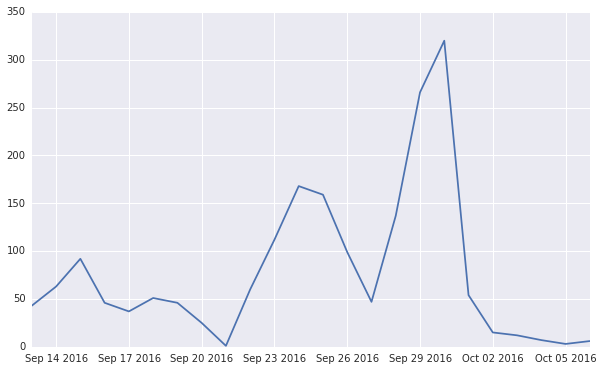

In [20]:
plt.figure(figsize=[10,6])
#df.groupby("test attempt").first()["day"].value_counts().sort_values().plot(x_compat=False)
df[df['day'] > pd.to_datetime('20160912', format='%Y%m%d').date()].groupby("test attempt").first()["day"].value_counts().plot()

# BoxPlot représentant les différentes cartes de l'atlas 

C:\Users\Armand\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


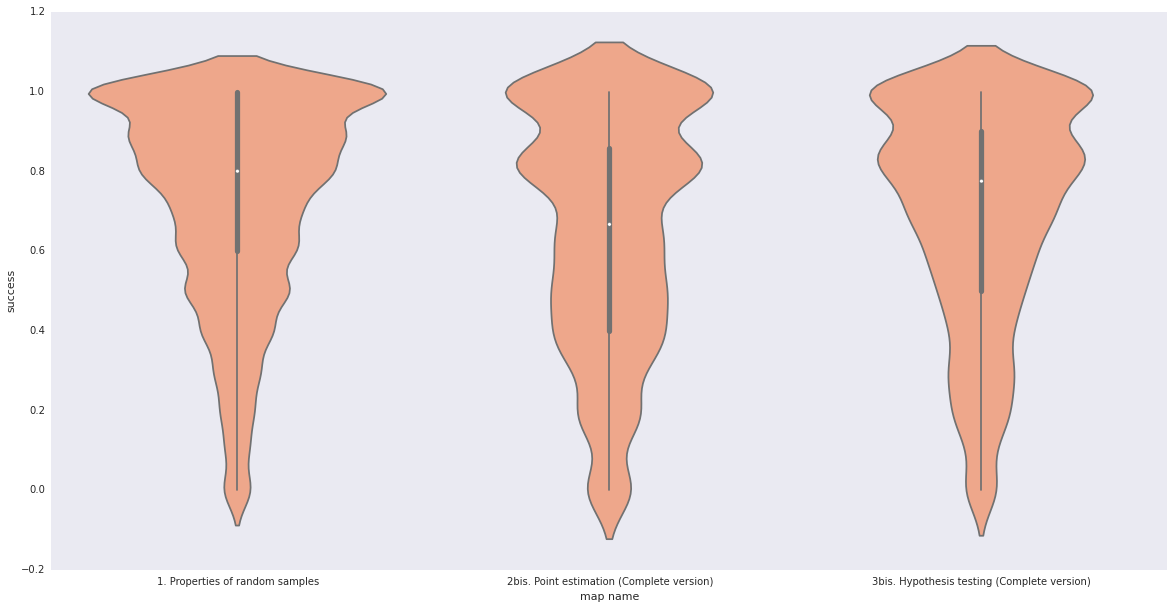

In [21]:


fig = plt.figure(figsize=[20,10])
df_map_name = df[["map name", "test attempt"]]
df_ta_mean = df.groupby('test attempt').mean().reset_index(level=0)[["success", 'test attempt']]
df_merge_map_name_success = pd.merge(left=df_map_name,right=df_ta_mean,on="test attempt")
#bp = df_merge_map_name_success.boxplot(by='map name',figsize=[10,10],rot=60)
sns.violinplot(x='map name',y='success', data=df_merge_map_name_success,orient='v', color='lightsalmon')
plt.savefig("boxplotdelenfer",transparent=True)

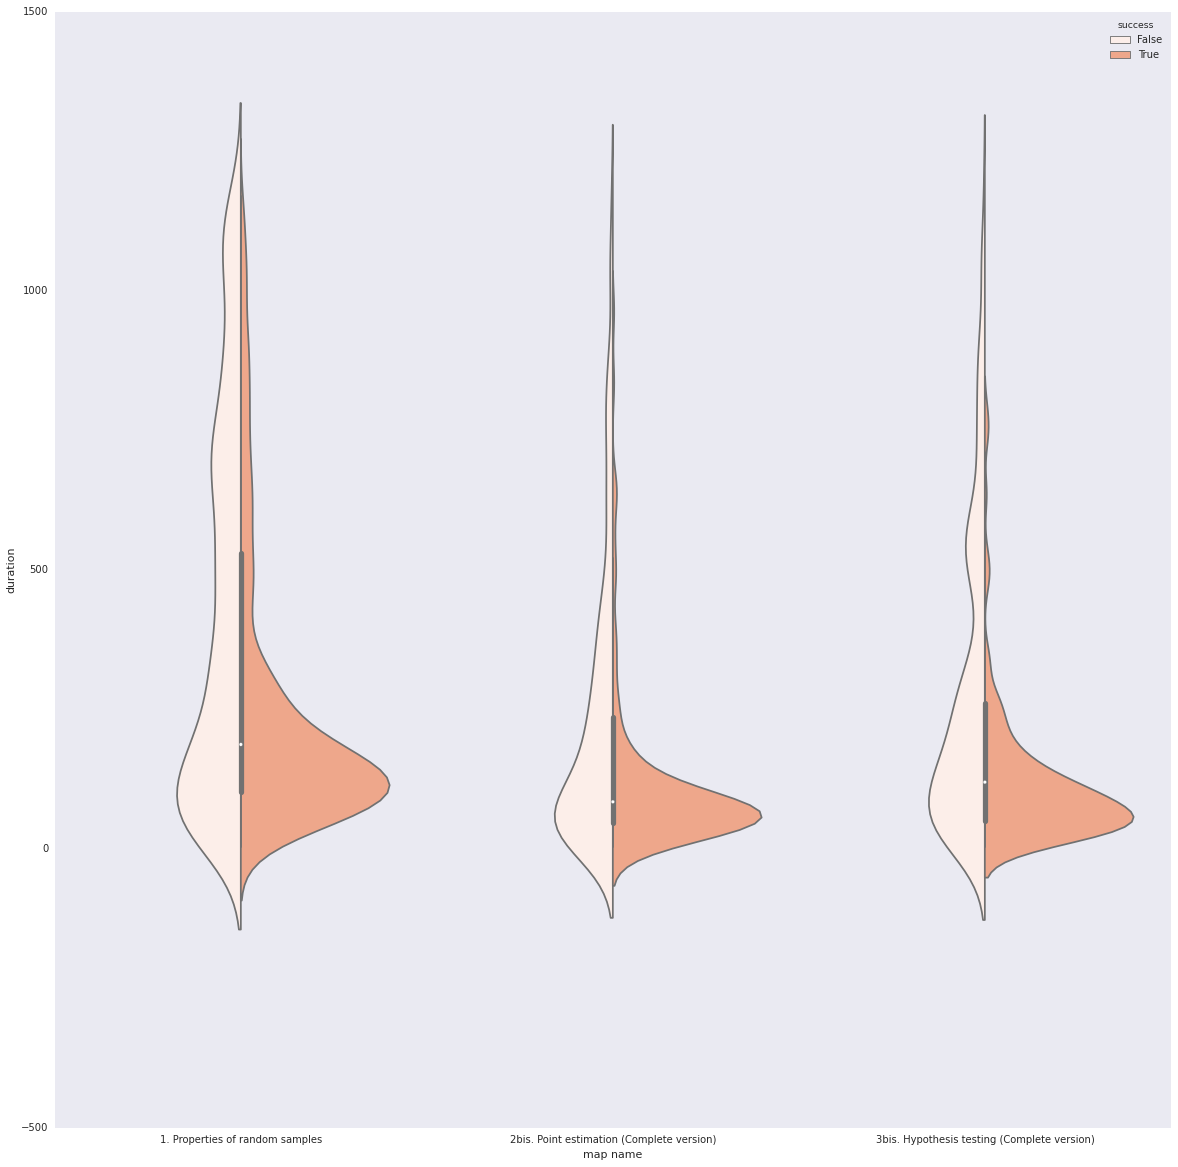

In [22]:
fig = plt.figure(figsize=[20,20])
df_map_name = df[["map name", "test attempt"]]
df_ta_dur = df.groupby('test attempt').aggregate({'duration':sum, 'success':(lambda x: mean(x) >.8)}).reset_index(level=0)
df_ta_dur = df_ta_dur[df_ta_dur["duration"] < 1200]
df_merge_map_name_duration = pd.merge(left=df_map_name,right=df_ta_dur,on="test attempt")
#bp = df_merge_map_name_duration.boxplot(by='map name',figsize=[10,10],rot=60)
sns.violinplot(x='map name',y='duration', data=df_merge_map_name_duration,orient='v',hue='success',split=True, color='lightsalmon')
plt.savefig('narwhalsareawesome',transparent=True)

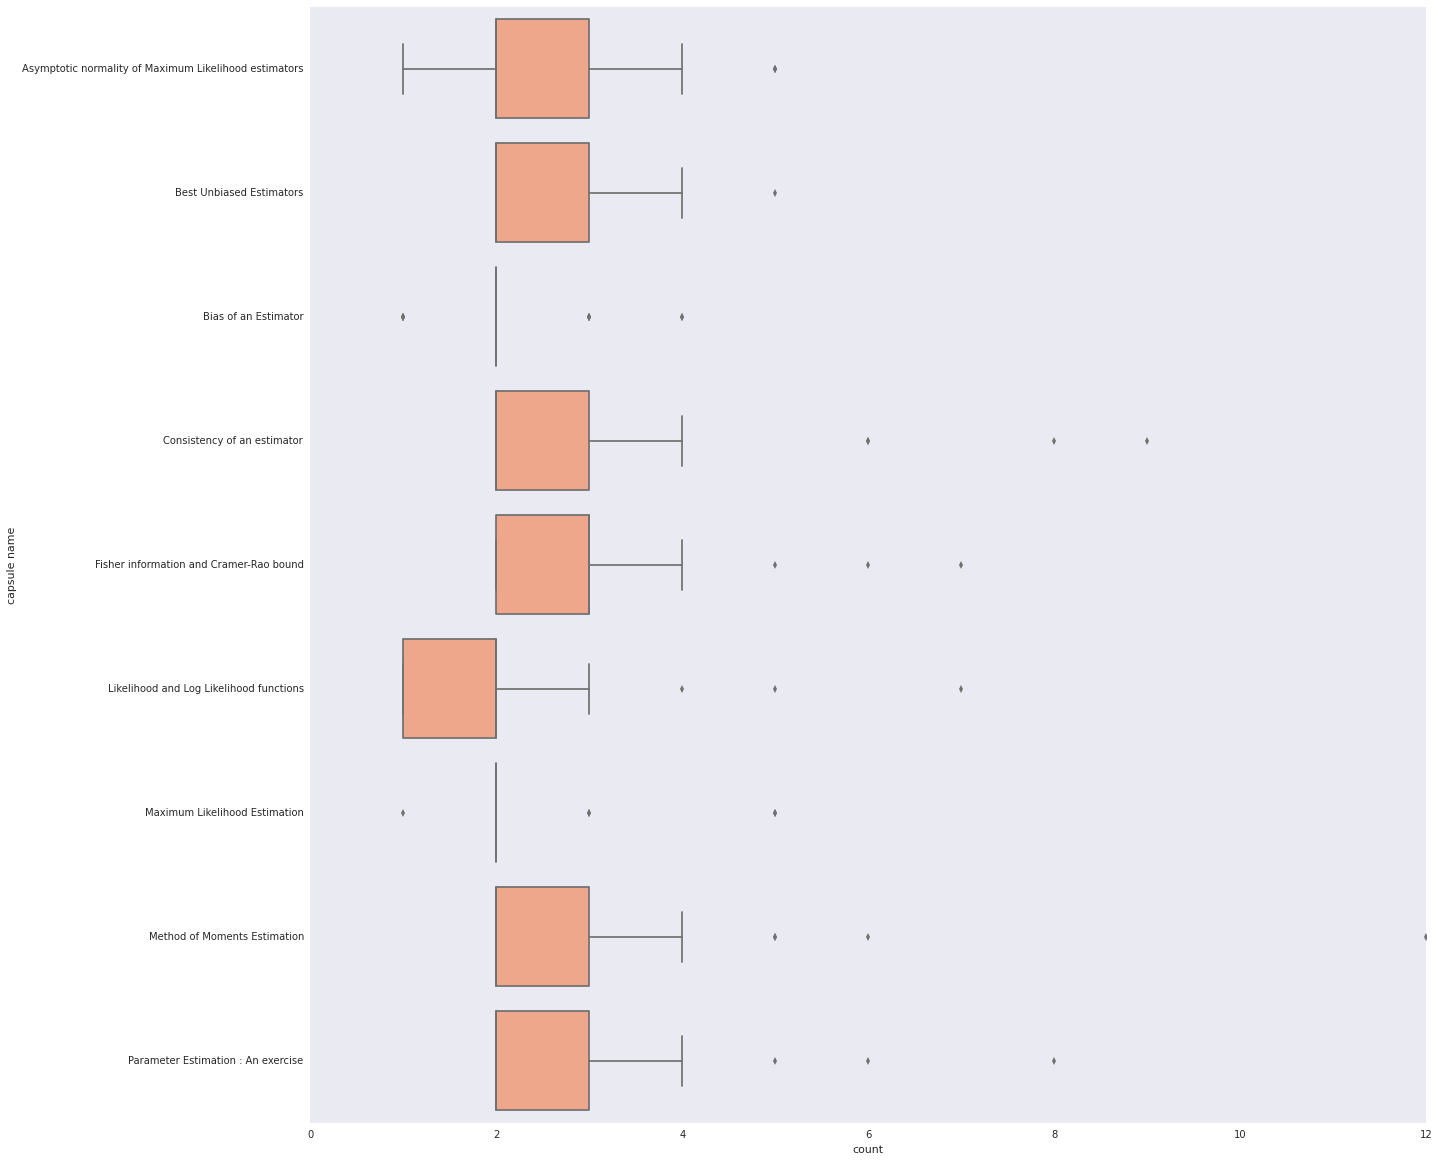

In [23]:
fig = plt.figure(figsize=[20,20])
#df_map_name = df[["map name", "test attempt"]]
#df_ta_mean = df.groupby('test attempt').mean().reset_index(level=0)[["success", 'test attempt']]
#df_merge_map_name_success = pd.merge(left=df_map_name,right=df_ta_mean,on="test attempt")
df_ta2_capsule_x_user = df_ta2.groupby(['capsule name', 'user id']).sum().reset_index(level=[0,1])
sns.boxplot(x='count',y='capsule name', data=df_ta2_capsule_x_user,orient='h', color='lightsalmon')
plt.savefig("boxplotdescapsuser",transparent=True)


# Box plot duration per number of attempt

In [24]:
u = df_ta2[df_ta2['duration in min'] < 20].sort(['user id', 'date created']).groupby(['capsule name','user name']).agg({"count":cumsum,'duration in min':(lambda x: x)})
u.reset_index(inplace=True)
u['count'] = u['count'].apply(lambda row: [row] if type(row) == np.float64 else row )
u['duration in min'] = u['duration in min'].apply(lambda row: [row] if type(row) == np.float64 else row )

rows = []
_ = u.apply(lambda row: [rows.append([row['capsule name'], row['user name'], nn, mm]) 
                         for nn,mm in zip(row['count'],row['duration in min'])], axis=1)
df_new = pd.DataFrame(rows, columns=u.columns)

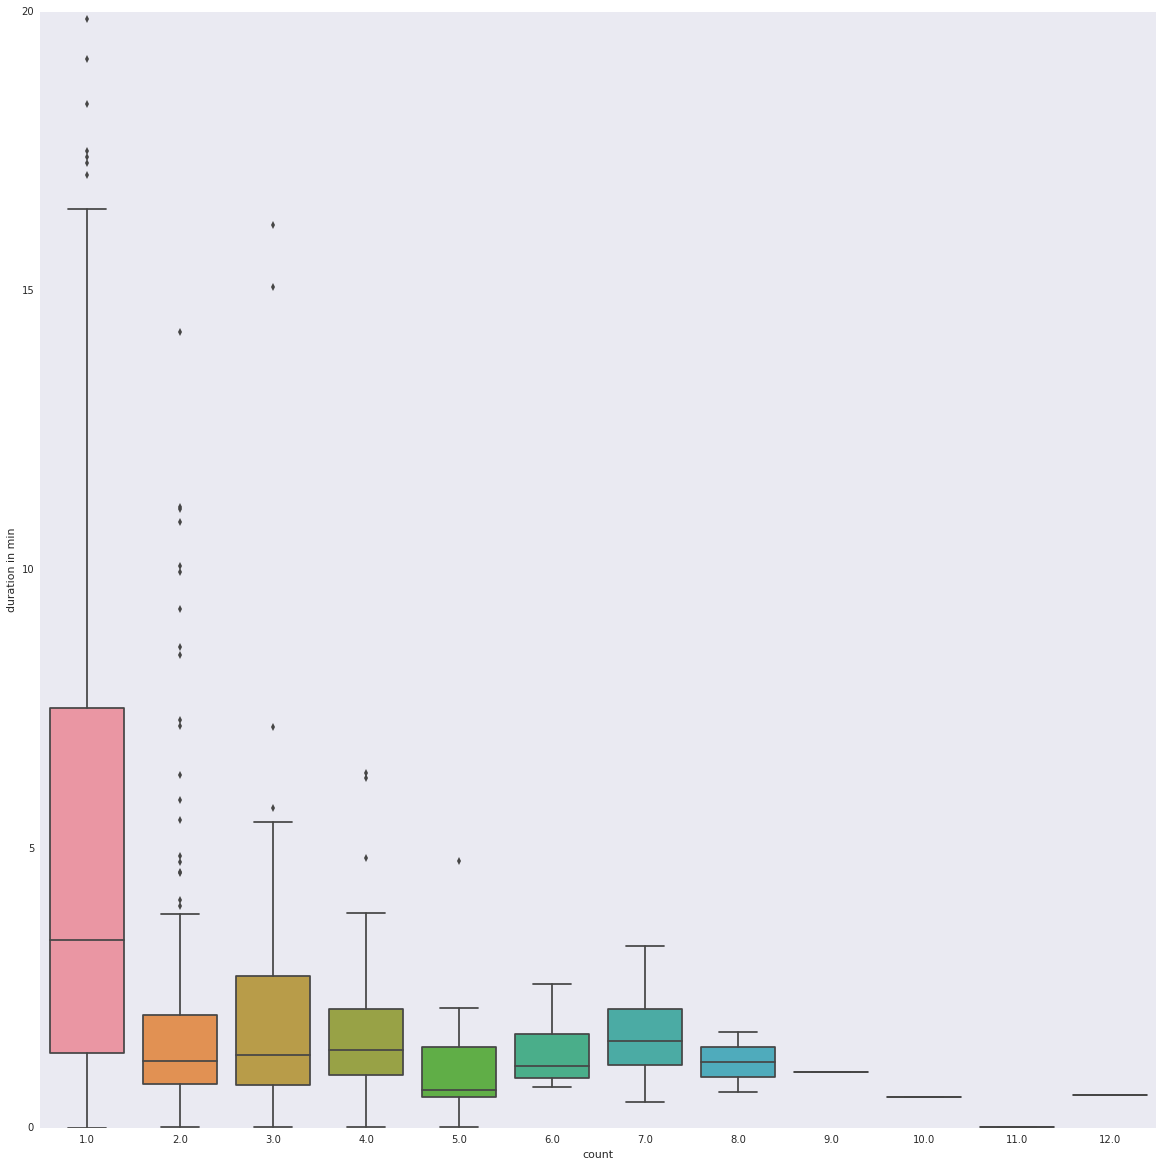

In [25]:
plt.figure(figsize=[20,20])
sns.boxplot(x='count',y='duration in min',data=df_new)
plt.savefig('boxplotattemptdur',transparent=True)

# Box plot score per number of attempt

In [26]:
u = df_ta2[df_ta2['duration in min'] < 80].sort(['user id', 'date created']).groupby(['capsule name','user name']).agg({"count":cumsum,'score':(lambda x: x)})
u.reset_index(inplace=True)
u['count'] = u['count'].apply(lambda row: [row] if type(row) == np.float64 else row )
u['score'] = u['score'].apply(lambda row: [row] if type(row) == np.float64 else row )

rows = []
_ = u.apply(lambda row: [rows.append([row['capsule name'], row['user name'], nn, mm]) 
                         for nn,mm in zip(row['count'],row['score'])], axis=1)
df_new2 = pd.DataFrame(rows, columns=u.columns)

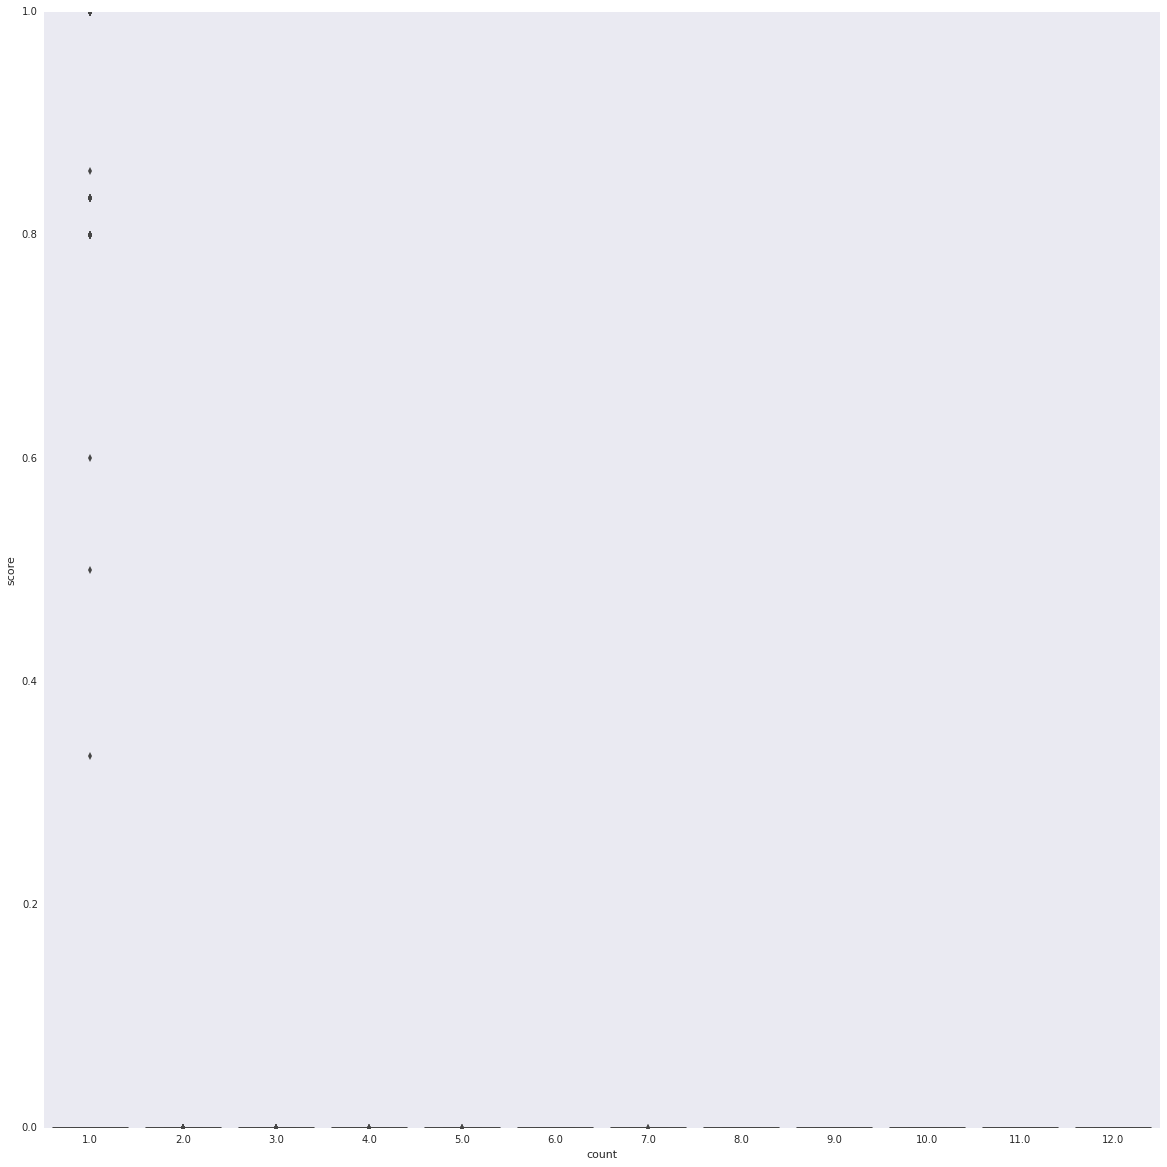

In [27]:
plt.figure(figsize=[20,20])
sns.boxplot(x='count',y='score',data=df_new2)
plt.savefig('boxplotattemptscore',transparent=True)

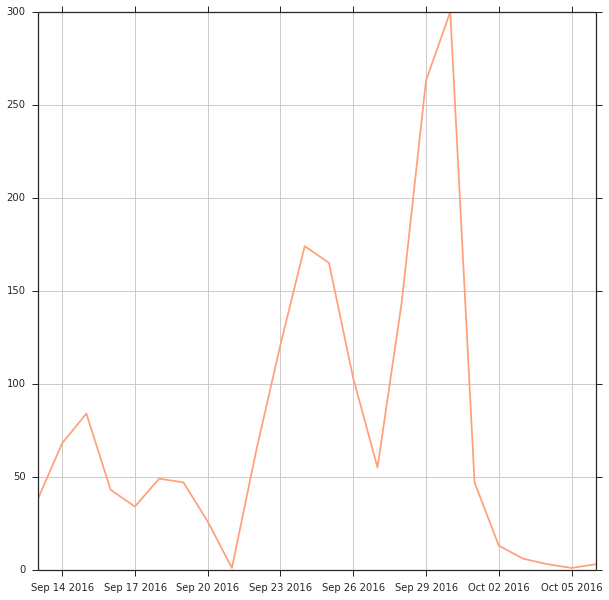

In [28]:
fig = plt.figure(figsize=[10,10])
sns.set_style("ticks")
df_ta["date"] = pd.DatetimeIndex(df_ta['date created']).date
df_ta['date'].value_counts().plot(color='lightsalmon')
plt.savefig("NumTAday.png",transparent=True)

# Number of test attempts at different connection hours

In [29]:
def color_matching(x):
    if x > .6:
        return 'red'
    elif .5 < x < .6:
        return 'orange'
    elif .4 < x < .5:
        return 'lightsalmon'
    elif .3 < x < .4:
        return 'gold'
    else:
        return 'b'


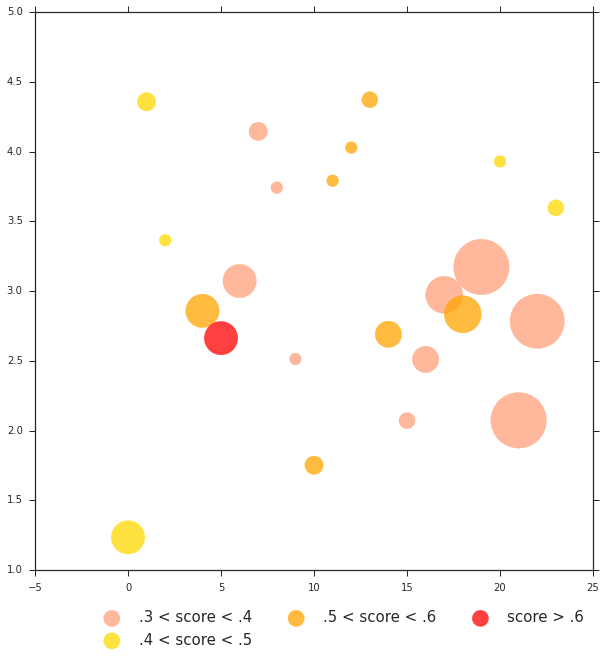

In [30]:
df_ta["hour"] = pd.DatetimeIndex(df_ta["date created"]).hour
x = df_ta["hour"].value_counts().sort_index().values
y = df_ta["hour"].value_counts().sort_index().keys()
s = df_ta[df_ta['duration in min'] < 60].groupby('hour').median()['duration in min']
colors = df_ta.groupby('hour').mean()['score'].apply(color_matching)
df_color = pd.DataFrame({'freq':x,'label':y,'color':colors,'size':s})
colors = ['lightsalmon','gold','orange','red']

fig = plt.figure(figsize=[10,10])
level = []
for color in colors:
    element_select = df_color["color"] == color
    level.append(plt.scatter(df_color[element_select]['label'], df_color[element_select]['size'],s=df_color['freq']*20,alpha=.75, color=color))
plt.legend(level,('.3 < score < .4', '.4 < score < .5', '.5 < score < .6', 'score > .6'),loc=[0.1,-0.15],ncol=3,fontsize=15, markerscale =.4)
plt.savefig('NumberTAconnecthour.png',transparent=True)
plt.show()

- Temps total que chaque étudiant y a passé (Atlas, Carte, Capsule) -> Proximité des vraies durées

- Pattern d'utilisation de la plateforme (profil-type) 1 tentative, combien de capsules avant de revenir, à quel point je persiste, par question.

-Première bosse : même utilisateurs ? 

- Progrès entre les tentatives, Est-ce que les gens enchaînent les tentatives ? 

- Quand je me suis trompé, plus de temps sur l'explication ?

- Consultation de la ressource

- Usage de la plateforme : est-ce que les gens changent leur manière de travailler dans le temps, est-ce que des gens ne reviennent pas. Décrochage, temps passé sur la première connexion. Score moyen première tentative : impact ? 

In [34]:
df_ta[df_ta['duration in min'] < 1000].groupby('user name').sum().describe()

,is completed,is succeeded,score,count,duration in min,hour
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,42.107143,24.392857,30.625553,62.392857,1902.657132,832.000000
std,18.296608,10.688655,13.219280,41.054020,1778.652339,562.730973
min,1.000000,0.000000,0.000000,1.000000,0.406983,15.000000
25%,37.250000,23.000000,28.019941,44.750000,645.561967,612.750000
50%,47.500000,27.000000,34.350000,56.500000,1079.560300,731.500000
75%,53.500000,30.000000,38.371726,75.500000,3174.970421,1029.250000
max,64.000000,42.000000,47.313095,177.000000,6705.662633,2636.000000


In [65]:
df_ta.groupby(['user name']).sum()/23

,is completed,is succeeded,score,count,duration in min,hour
user name,,,,,,
Alexis Ghersengorin,2.347826,1.304348,1.745704,2.347826,599.159470,33.043478
Amit Dekel,1.956522,1.304348,1.610766,3.391304,1109.550948,47.739130
Antonela Miho,2.434783,1.826087,2.057091,7.782609,233.291166,115.739130
Arnaud Riegert,0.086957,0.086957,0.082609,0.130435,76.497196,1.043478
Arthur Contejean,2.739130,1.434783,1.992236,4.260870,574.291143,59.826087
Awonon Josué AWONON,2.391304,1.695652,1.921739,5.695652,565.478849,76.608696
Ben Krieble,2.826087,1.304348,1.913665,3.043478,140.687002,39.391304
Catalina AGNES,0.826087,0.391304,0.501812,1.043478,318.895161,14.956522
Chin-Te LIN,2.913043,1.304348,1.725983,3.913043,307.932112,56.739130


In [ ]:
from sklearn.decomposition import PCA

clf = PCA()

clf.fit()